In [1]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
electronics_data=pd.read_csv("ratings_Electronics (1).csv", names=['userid','productId','rating','timestamp'])

In [4]:
electronics_data.head()

,userid,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
electronics_data.shape

(7824482, 4)

In [6]:
eletronics_data=electronics_data.iloc[:1048576,0:]

In [7]:
eletronics_data.dtypes

userid        object
productId     object
rating       float64
timestamp      int64
dtype: object

In [8]:
eletronics_data.describe()['rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [9]:
print("max of rating : %d" %(eletronics_data.rating.max()))
print("min of rating : %d" %(eletronics_data.rating.min()))

max of rating : 5
min of rating : 1


### Missing value수

In [10]:
print('Number of missing values across columns: \n',eletronics_data.isnull().sum())

Number of missing values across columns: 
 userid       0
productId    0
rating       0
timestamp    0
dtype: int64


### Ratings

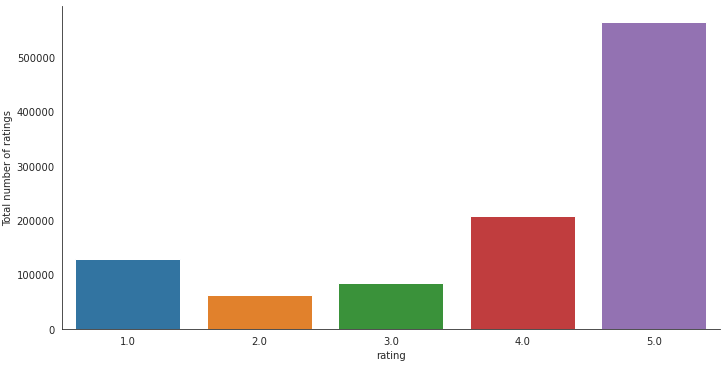

In [11]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data  = eletronics_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [12]:
print('total data')
print('-'*50)
print("\nTotal num of ratings :", eletronics_data.shape[0])
print("Total num of Users :", len(np.unique(eletronics_data.userid )))
print("Total num of products: ", len(np.unique(eletronics_data.productId)))

total data
--------------------------------------------------

Total num of ratings : 1048576
Total num of Users : 786330
Total num of products:  61894


In [13]:
eletronics_data.drop(['timestamp'],axis = 1, inplace = True)

In [14]:
eletronics_data.head()

,userid,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Rating 분석

In [15]:
num_of_rated_products_per_user = eletronics_data.groupby(by = 'userid')['rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userid
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: rating, dtype: int64

In [16]:
num_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: rating, dtype: float64

#### 거의 모든 user들이 하나의 product에만 평가한 것을 확인 가능하다

In [17]:
quantiles=num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [18]:
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantilesand their Values')

<AxesSubplot:title={'center':'Quantilesand their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

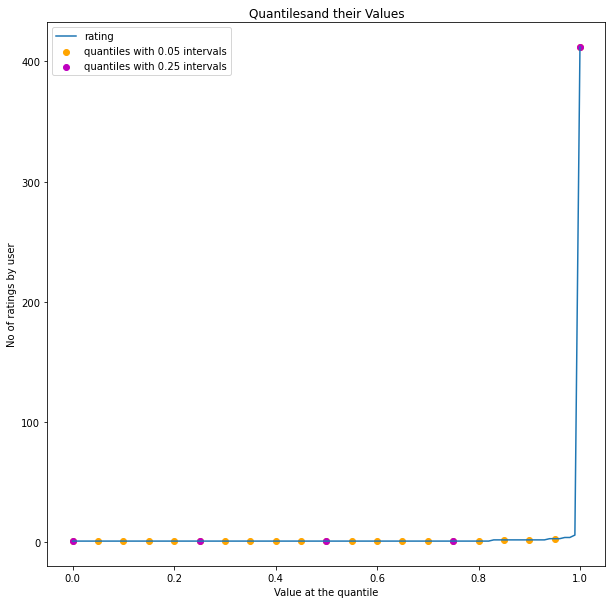

In [19]:
plt.figure(figsize=(10,10))
plt.title('Quantilesand their Values')
quantiles.plot()

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

### popularity Based Recommendation

In [20]:
#평가가 50번 이상 된 상품들을 가져옴
new_df=electronics_data.groupby("productId").filter(lambda x:x['rating'].count() >=50)

In [21]:
new_df.head()

,userid,productId,rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [22]:
new_df.shape

(5374313, 4)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-5000.0, 0, ''),
 Text(0.0, 0, ''),
 Text(5000.0, 0, ''),
 Text(10000.0, 0, ''),
 Text(15000.0, 0, ''),
 Text(20000.0, 0, ''),
 Text(25000.0, 0, ''),
 Text(30000.0, 0, '')]

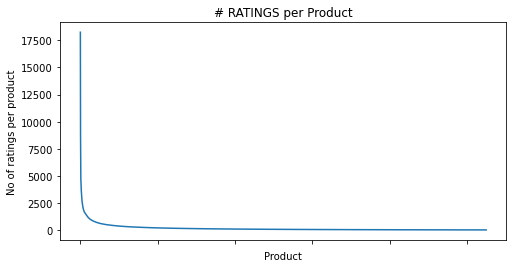

In [23]:
num_of_ratings_per_product = new_df.groupby(by='productId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [24]:
new_df.groupby('productId')['rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: rating, dtype: float64

In [25]:
new_df.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B002E6R7NG    4.980392
B004I763AW    4.966667
B003J9QQWU    4.964286
B0043ZLFXE    4.955556
B000TMFYBO    4.953125
Name: rating, dtype: float64

In [26]:
#평가된 수를 기준으로 내림차순 정렬

In [27]:
new_df.groupby('productId')['rating'].count().sort_values(ascending=False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: rating, dtype: int64

In [28]:
ratings_mean_count=pd.DataFrame(new_df.groupby('productId')['rating'].mean())

In [29]:
ratings_mean_count.head()

,rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [30]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['rating'].count())

In [31]:
ratings_mean_count.head()

,rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [32]:
ratings_mean_count['rating_counts'].max()

18244

<Figure size 432x432 with 0 Axes>

<AxesSubplot:>

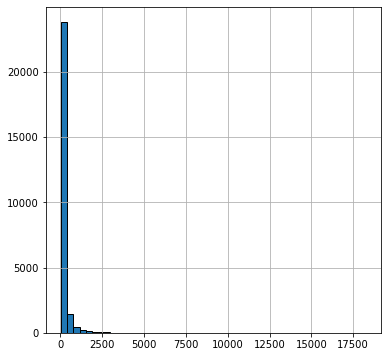

In [33]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

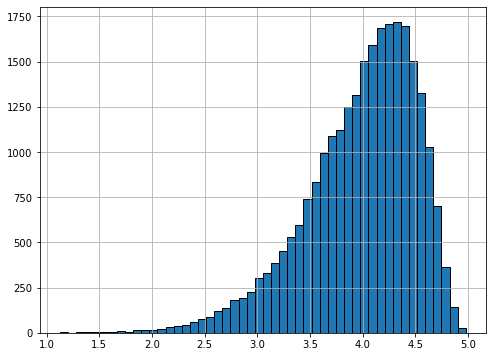

In [34]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

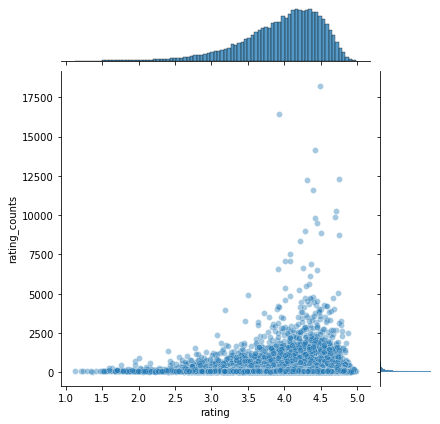

In [35]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='productId'>

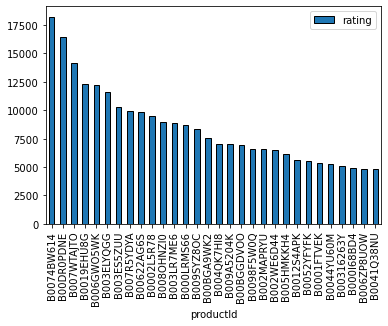

In [36]:
popular_products = pd.DataFrame(new_df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values("rating", ascending=False)
most_popular.head(30).plot(kind = "bar")

### Collaborative Filtering이용

In [37]:
!pip3 install surprise

In [38]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

## data 가져오기

In [39]:
new_df.drop(['timestamp'],axis=1, inplace=True)


In [40]:
reader= Reader(rating_scale=(1,5))
data=Dataset.load_from_df(new_df, reader)

## trainset, testset으로 나누기

In [41]:
trainset, testset= train_test_split(data, test_size=0.3, random_state=10)

## KNN을 이용 trainset에 파라미터 맞추기

In [43]:
algo = KNNWithMeans(k=5, sim_options = {'name': 'pearson_baseline', 'user_based':False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## Test accuracy 측정

In [44]:
test_pred= algo.test(testset)

In [45]:
print('item-based Model : Test Set')
accuracy.rmse(test_pred, verbose=True)

item-based Model : Test Set
RMSE: 1.3335


1.3334560899557941

## Model-based collaborative filtering system

In [46]:
# 대량의 sample, 많은 사용자들에거 추천 가능, sparse한 matrices에도 사용가능

In [56]:
new_df1= new_df.head(10000)
new_df1.head(10)

,userid,productId,rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
188,AOZZ0CTG5RMW1,0972683275,4.0
189,A2IDCSC6NVONIZ,0972683275,5.0
190,AML8NIWFKHZJU,0972683275,3.0
191,A33HBPL7Q6SZMG,0972683275,5.0
192,A22JDDJB1ZLGGZ,0972683275,5.0


In [57]:
ratings_matrix = new_df1.pivot_table(values ='rating', index ='userid', columns ='productId',fill_value =0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userid,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
ratings_matrix.shape

(9832, 76)

In [59]:
X= ratings_matrix.T
X.head()

userid,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
X.shape

(76, 9832)

In [61]:
X.index

Index(['0972683275', '1400501466', '1400501520', '1400501776', '1400532620',
       '1400532655', '140053271X', '1400532736', '1400599997', '1400698987',
       '3744295508', '6301977173', '7214047977', '8862935293', '9573212919',
       '9575871979', '9625993428', '9888002198', '9966694544', '9983891212',
       '9984984354', '9985511476', 'B000001OM4', 'B000001OM5', 'B000001OMI',
       'B000001ON6', 'B00000DM9W', 'B00000IGBF', 'B00000J05A', 'B00000J061',
       'B00000J08Q', 'B00000J0D2', 'B00000J0D5', 'B00000J0D8', 'B00000J1EJ',
       'B00000J1EP', 'B00000J1EQ', 'B00000J1F3', 'B00000J1GA', 'B00000J1QK',
       'B00000J1QR', 'B00000J1SC', 'B00000J1TX', 'B00000J1U8', 'B00000J1UQ',
       'B00000J1V3', 'B00000J1V5', 'B00000J3NF', 'B00000J3Q7', 'B00000J3UJ',
       'B00000J434', 'B00000J4EY', 'B00000J4FS', 'B00000J4GE', 'B00000J6WY',
       'B00000JBAT', 'B00000JBHP', 'B00000JBPB', 'B00000JCT8', 'B00000JCTO',
       'B00000JD34', 'B00000JDF5', 'B00000JDF6', 'B00000JDHV', 'B00000JFE3',

In [62]:
X1= X

In [63]:
from sklearn.decomposition import TruncatedSVD
SVD=TruncatedSVD(n_components=10)
decomposed_matrix=SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [64]:
decomposed_matrix

array([[ 1.48104508e+02, -1.54594960e-01,  2.45296906e-02,
         1.53803568e-04, -1.34146810e-01,  1.14574565e-05,
         4.60538289e-02,  3.35048063e-05,  7.37938050e-04,
        -8.42622562e-02],
       [ 6.69065546e-04,  1.27559691e+00,  1.49788658e+00,
         1.91127984e-01, -2.54405208e-03,  4.06279679e-02,
         5.33116454e-02, -3.06433325e-03,  6.10010017e+01,
        -4.00571418e-01],
       [ 4.51497807e-05,  1.00869402e-01,  3.19011757e-01,
        -2.17542587e-03,  1.17704280e-03,  1.04807361e-02,
         9.57934366e-03,  6.98202360e-02,  1.42200371e+00,
        -1.21571443e-01],
       [ 6.22715482e-04,  7.81150457e-01,  4.93246187e-01,
        -2.77723414e-02, -4.76377528e-02,  5.52139080e-02,
         2.15460995e-02,  5.93473535e-01,  3.77834152e+00,
        -1.21834702e+00],
       [ 4.04930497e-04,  7.65256532e-01,  1.09188567e+00,
         4.68893127e-03,  2.34847090e-02,  1.91597086e-02,
         7.23639017e-02, -5.47041511e-01, -1.56198217e+00,
         1.

In [65]:
correlation_matrix=np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [66]:
X.index[75]

'B00000K135'

In [68]:
i = X.index[75]

product_names = list(X.index)
product_ID= product_names.index(i)
product_ID

75

In [70]:
correlation_matrix_ID= correlation_matrix[product_ID]
correlation_matrix_ID.shape

(76,)

In [71]:
correlation_matrix_ID

array([-8.47694053e-02,  1.61349613e-01,  4.27477258e-02, -2.06723345e-01,
        3.43484597e-01, -7.42007450e-02, -1.10798870e-01,  9.69573720e-02,
        9.02438532e-08,  2.14831145e-01, -7.59188820e-01, -4.19526156e-01,
        4.19991976e-01,  8.65560663e-01,  3.08464689e-01, -9.01530251e-01,
        9.09793479e-01, -9.13386188e-01,  2.98791028e-01,  9.07660166e-01,
        2.75712368e-01,  3.66001036e-01,  7.58467119e-01,  7.53584727e-01,
       -4.57038609e-01, -1.22189290e-01, -5.93094502e-02, -2.96367865e-01,
       -4.12418939e-01, -4.55769131e-01,  9.55730010e-01, -2.15812110e-01,
        9.51419730e-01, -2.43449774e-01, -8.56554377e-01, -2.35292605e-01,
        3.43908043e-01, -1.21049912e-01, -2.38626080e-02,  7.20614300e-02,
        2.57194953e-01, -6.84416818e-01, -2.29612634e-01,  7.18020044e-01,
       -2.33103293e-01,  4.77828290e-01, -4.04133704e-02,  2.32095356e-01,
       -4.38263503e-01, -7.44136414e-01, -4.85418287e-02,  6.37335016e-01,
        6.01105627e-02, -

In [74]:
Recommend= list(X.index[correlation_matrix_ID> 0.65])
# 피어슨 상관계수가 0.65보다 큰 상품들의 index의 list reuturn

Recommend.remove(i)
# 이미 구입한 상품은 뺀다
Recommend[0:24] 

['8862935293',
 '9625993428',
 '9983891212',
 'B000001OM4',
 'B000001OM5',
 'B00000J08Q',
 'B00000J0D5',
 'B00000J1U8',
 'B00000JDHV',
 'B00000JII6']

In [75]:
Recommend

['8862935293',
 '9625993428',
 '9983891212',
 'B000001OM4',
 'B000001OM5',
 'B00000J08Q',
 'B00000J0D5',
 'B00000J1U8',
 'B00000JDHV',
 'B00000JII6']